In [80]:
from datetime import datetime
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image

%matplotlib inline

In [81]:
def read_mta(file_nums):
    path ='http://web.mta.info/developers/data/nyct/turnstile/turnstile_'
    allFiles = []
    for i in file_nums:
        allFiles.append(path + i + ".txt")
    df_list = [pd.read_csv(file) for file in allFiles]
    df = pd.concat(df_list)
    df.columns = df.columns.str.strip()
    return df

In [82]:
df = read_mta(['191228', '191221', '191214', '191207','191130','191123','191116','191109','191102','191026','191019','191012','191005'])

In [134]:
 df[df.DESC == 'RECOVR AUD']

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
DATETIME,,,,,,,,,,,


In [149]:
# remove duplicates
df = df[df.DESC != 'RECOVR AUD']
df = df[df.TIME != '04:01:13']
# Sanity check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(df
 .groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME'])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head()

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,09/28/2019,00:00:00,1
1779372,R138,R293,00-02-02,34 ST-PENN STA,12/22/2019,17:00:00,1
1779354,R138,R293,00-02-02,34 ST-PENN STA,12/19/2019,17:00:00,1
1779355,R138,R293,00-02-02,34 ST-PENN STA,12/19/2019,21:00:00,1
1779356,R138,R293,00-02-02,34 ST-PENN STA,12/20/2019,01:00:00,1


In [150]:
# data is at a turnstile level
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
DATETIME,,,,,,,,,,,
2019-12-21 03:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/21/2019,03:00:00,REGULAR,7318040,2480587
2019-12-21 07:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/21/2019,07:00:00,REGULAR,7318049,2480598
2019-12-21 15:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/21/2019,15:00:00,REGULAR,7318263,2480763
2019-12-21 19:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/21/2019,19:00:00,REGULAR,7318559,2480823
2019-12-21 23:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/21/2019,23:00:00,REGULAR,7318742,2480852


In [86]:
df['DATETIME'] = pd.to_datetime(df.DATE + ' ' + df.TIME)

In [87]:
df = df.set_index(['DATETIME'])
#df.head()

In [88]:
# filter dataset to 11:59am to 8pm
afternoon = df.between_time('11:59:00', '20:01:00')
afternoon.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
DATETIME,,,,,,,,,,,
2019-12-21 15:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/21/2019,15:00:00,REGULAR,7318263,2480763
2019-12-21 19:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/21/2019,19:00:00,REGULAR,7318559,2480823
2019-12-22 15:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/22/2019,15:00:00,REGULAR,7318995,2480969
2019-12-22 19:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/22/2019,19:00:00,REGULAR,7319219,2481016
2019-12-23 15:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/23/2019,15:00:00,REGULAR,7319773,2481385


In [89]:
# subtract max from min for each turnstile to get exits
afternoon_turn = (afternoon.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])['EXITS'].max()\
           -afternoon.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])['EXITS'].min()).reset_index()

In [90]:
#explore outliers
afternoon_turn['EXITS'].describe()

count    4.442810e+05
mean     7.809241e+03
std      3.140219e+06
min      0.000000e+00
25%      4.600000e+01
50%      1.730000e+02
75%      4.150000e+02
max      1.845494e+09
Name: EXITS, dtype: float64

In [91]:
afternoon_turn['EXITS'].sort_values(ascending = True).tail(10)

333495       2000290
414559       2935531
294518       6881704
11234        9758569
25283       14890810
368592      50412910
210680     100845153
366627     384304583
380051     902457006
280945    1845493769
Name: EXITS, dtype: int64

In [92]:
# removing values that appear to be counter resets
afternoon_turn = afternoon_turn[afternoon_turn.EXITS <= 11000]

In [93]:
afternoon_turn.head()
#afternoon_turn.shape

,C/A,UNIT,SCP,STATION,DATE,EXITS
0,A002,R051,02-00-00,59 ST,09/28/2019,72
1,A002,R051,02-00-00,59 ST,09/29/2019,104
2,A002,R051,02-00-00,59 ST,09/30/2019,101
3,A002,R051,02-00-00,59 ST,10/01/2019,116
4,A002,R051,02-00-00,59 ST,10/02/2019,139


In [94]:
# add up total afternoon exits per station
afternoon_station = afternoon_turn.groupby(['STATION', 'DATE']).sum().reset_index()
afternoon_station['DATE'] = pd.to_datetime(afternoon_station['DATE'])
afternoon_station.head()

,STATION,DATE,EXITS
0,1 AV,2019-09-28,3665
1,1 AV,2019-09-29,2690
2,1 AV,2019-09-30,8573
3,1 AV,2019-10-01,8820
4,1 AV,2019-10-02,10283


In [95]:
# summing for whole month
afternoon_month = afternoon_station.groupby(['STATION'])['EXITS'].sum().reset_index()
afternoon_month = afternoon_month.set_index('STATION')

<AxesSubplot:title={'center':'Afternoon Exits by Station'}, ylabel='STATION'>

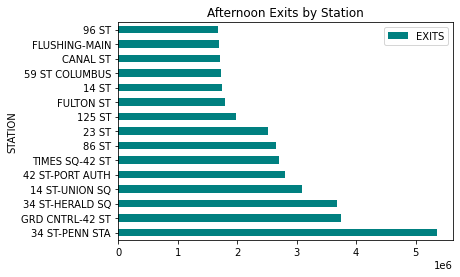

In [118]:
# determine busiest stations
topsts = afternoon_month.sort_values('EXITS', ascending=False).head(15)
topsts.head()
topsts.plot(kind='barh', title='Afternoon Exits by Station', color = '#008080')

In [97]:
# limit to Grand Central at turnstile level
grdcentral = df[df['STATION'] == 'GRD CNTRL-42 ST']

In [98]:
grdcentral.shape

(39097, 11)

In [99]:
grdcentral.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
DATETIME,,,,,,,,,,,
2019-12-21 00:00:00,R236,R045,00-00-00,GRD CNTRL-42 ST,4567S,IRT,12/21/2019,00:00:00,REGULAR,2310699,6153520
2019-12-21 04:00:00,R236,R045,00-00-00,GRD CNTRL-42 ST,4567S,IRT,12/21/2019,04:00:00,REGULAR,2310701,6153522
2019-12-21 08:00:00,R236,R045,00-00-00,GRD CNTRL-42 ST,4567S,IRT,12/21/2019,08:00:00,REGULAR,2310714,6153595
2019-12-21 12:00:00,R236,R045,00-00-00,GRD CNTRL-42 ST,4567S,IRT,12/21/2019,12:00:00,REGULAR,2310748,6153849
2019-12-21 16:00:00,R236,R045,00-00-00,GRD CNTRL-42 ST,4567S,IRT,12/21/2019,16:00:00,REGULAR,2310904,6154176


In [124]:
exits_turn = exits_turn[exits_turn['DIFFS'] >= 0]

In [139]:
# now have turnstile exits per four period (diffs column)
#exits_turn.tail()
#exits_turn
exits_turn[(exits_turn.DATE=='12/12/2019')].DIFFS.sum()

21014.0

In [140]:
exits_turn.tail()

,level_0,index,DATETIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DIFFS
5908,5908,5908,2019-10-04 05:00:00,R236,R045,00-06-01,GRD CNTRL-42 ST,4567S,IRT,10/04/2019,05:00:00,REGULAR,6671512,3417307,1.0
5909,5909,5909,2019-10-04 09:00:00,R236,R045,00-06-01,GRD CNTRL-42 ST,4567S,IRT,10/04/2019,09:00:00,REGULAR,6671590,3417377,70.0
5910,5910,5910,2019-10-04 13:00:00,R236,R045,00-06-01,GRD CNTRL-42 ST,4567S,IRT,10/04/2019,13:00:00,REGULAR,6671836,3417474,97.0
5911,5911,5911,2019-10-04 17:00:00,R236,R045,00-06-01,GRD CNTRL-42 ST,4567S,IRT,10/04/2019,17:00:00,REGULAR,6672556,3417551,77.0
5912,5912,5912,2019-10-04 21:00:00,R236,R045,00-06-01,GRD CNTRL-42 ST,4567S,IRT,10/04/2019,21:00:00,REGULAR,6673392,3417565,14.0


In [126]:
# add exits across turnstiles by time
exits_turn = exits_turn.reset_index()
ct = exits_turn.groupby(['DATETIME'])['DIFFS'].sum().reset_index()

In [127]:
ct.set_index(['DATETIME'], inplace=True)
ct.head()

,DIFFS
DATETIME,
2019-09-28 01:00:00,18210.0
2019-09-28 05:00:00,4.0
2019-09-28 09:00:00,712.0
2019-09-28 13:00:00,1510.0
2019-09-28 17:00:00,1766.0


<AxesSubplot:title={'center':'Number of People Exiting Grand Central for One Day'}, xlabel='DATETIME'>

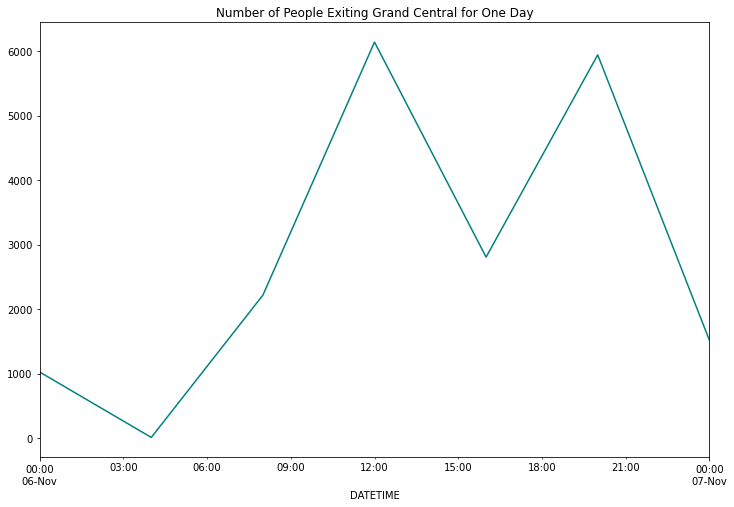

In [128]:
plt.figure(figsize=(12,8))


plt.xticks(rotation=200)
weekday1 = ct[(ct.index > '2019-11-05 21:00:00') & (ct.index < '2019-11-07 03:00:00')]
weekday1['DIFFS'].plot(title = 'Number of People Exiting Grand Central for One Day', color = '#008080' )